# 2.2.10 例題: スペースシャトル「チャレンジャー号」の悲劇

In [29]:
using Distributed
addprocs(3)

using CSV
using DataFrames
using HTTP
using LaTeXStrings
using LinearAlgebra
@everywhere using Mamba
using Plots

## データの取得 & 加工

In [30]:
r = HTTP.request("GET", "https://git.io/vXknD");

In [31]:
challengers_data = CSV.read(IOBuffer(r.body))
names!(challengers_data, [:date, :temperature, :incident])
# incidentのパース
challengers_data[:incident] = tryparse.(Int64, challengers_data[:incident])
# NaNを削除
challengers_data = challengers_data[challengers_data[:incident] .!= nothing, :]
challengers_data[:incident] = convert.(Int64, challengers_data[:incident])
disallowmissing!(challengers_data)

,date,temperature,incident
,String,Int64,Int64
1,04/12/1981,66,0
2,11/12/1981,70,1
3,3/22/82,69,0
4,01/11/1982,68,0
5,04/04/1983,67,0
6,6/18/83,72,0
7,8/30/83,73,0
8,11/28/83,70,0
9,02/03/1984,57,1


In [32]:
temperature = challengers_data[:temperature]
color_weight = (temperature .- minimum(temperature)) ./ (maximum(temperature) .- minimum(temperature))

23-element Array{Float64,1}:
 0.4642857142857143 
 0.6071428571428571 
 0.5714285714285714 
 0.5357142857142857 
 0.5                
 0.6785714285714286 
 0.7142857142857143 
 0.6071428571428571 
 0.14285714285714285
 0.35714285714285715
 0.6071428571428571 
 0.8928571428571429 
 0.5                
 0.0                
 0.5                
 0.7857142857142857 
 0.6071428571428571 
 1.0                
 0.8214285714285714 
 0.9285714285714286 
 0.7857142857142857 
 0.8214285714285714 
 0.17857142857142858

## データの図示

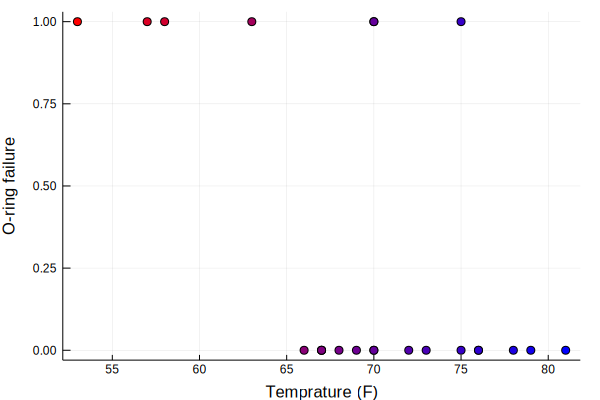

In [33]:
scatter(challengers_data.temperature, challengers_data.incident, 
        markercolor = weighted_color_mean.(color_weight, colorant"blue", colorant"red"), 
        xlabel = "Temprature (F)", ylabel = "O-ring failure", label = "")

## ロジスティック関数を表示する

In [103]:
function logistic(x, alpha, beta)
    1.0 ./ (1.0 .+ exp.(beta * x .+ alpha))
end

logistic (generic function with 1 method)

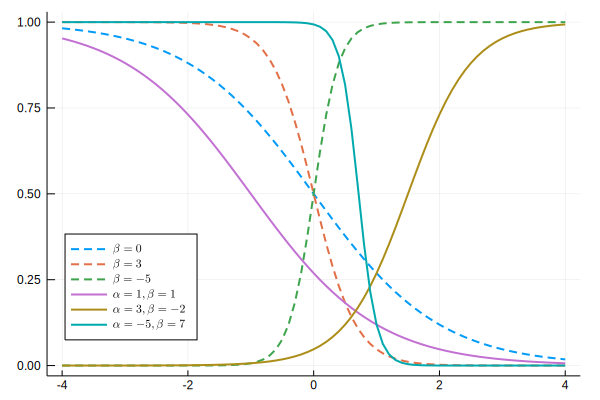

In [104]:
x = -4:0.1:4
Plots.plot(x, logistic.(x, 0, 1), linestyle = :dash, linewidth = 2, label = L"\beta = 0",
    legend = :bottomleft)
Plots.plot!(x, logistic.(x, 0, 3), linestyle = :dash, linewidth = 2, label = L"\beta = 3")
Plots.plot!(x, logistic.(x, 0, -5), linestyle = :dash, linewidth = 2, label = L"\beta = -5")
Plots.plot!(x, logistic.(x, 1, 1), linewidth = 2, label = L"\alpha = 1, \beta = 1")
Plots.plot!(x, logistic.(x, 3, -2), linewidth = 2, label = L"\alpha = 3, \beta = -2")
Plots.plot!(x, logistic.(x, -5, 7), linewidth = 2, label = L"\alpha = -5, \beta = 7")

## チャレンジャー号のモデリング

In [91]:
model = Model(
    
    observed = Stochastic(1,
        (alpha, beta, temperature) -> 
            UnivariateDistribution[
                Bernoulli(1.0 / (1.0 + exp(beta * x + alpha)))
            for x in temperature],
        false
    ),
    
    alpha = Stochastic(() -> Normal(0, sqrt(1000))),
    beta = Stochastic(() -> Normal(0, sqrt(1000))),

)

Object of type "Model"
-------------------------------------------------------------------------------
alpha:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
observed:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]


In [92]:
data = Dict{Symbol, Any}(
    :observed => challengers_data[:incident],
    :temperature => challengers_data[:temperature],
)

Dict{Symbol,Any} with 2 entries:
  :temperature => [66, 70, 69, 68, 67, 72, 73, 70, 57, 63  …  53, 67, 75, 70, 8…
  :observed    => [0, 1, 0, 0, 0, 0, 0, 0, 1, 1  …  1, 0, 0, 0, 0, 0, 0, 1, 0, …

In [38]:
inits = [
    Dict{Symbol, Any}(
        :observed => challengers_data[:incident],
        :alpha => 0,
        :beta => 0,
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:alpha=>0,:beta=>0,:observed=>[0, 1, 0, 0, 0, 0, 0, 0, 1, 1  …  1, 0, 0, 0, 0, 0, 0, 1, 0, 1])
 Dict(:alpha=>0,:beta=>0,:observed=>[0, 1, 0, 0, 0, 0, 0, 0, 1, 1  …  1, 0, 0, 0, 0, 0, 0, 1, 0, 1])
 Dict(:alpha=>0,:beta=>0,:observed=>[0, 1, 0, 0, 0, 0, 0, 0, 1, 1  …  1, 0, 0, 0, 0, 0, 0, 1, 0, 1])

In [39]:
scheme = [AMWG([:alpha, :beta], 0.1)]

1-element Array{Sampler{Mamba.AMWGTune},1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:alpha, :beta]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 0.1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any


In [40]:
setsamplers!(model, scheme)
sim = mcmc(model, data, inits, 200000, burnin = 50000, thin = 50, chains = 3)

MCMC Simulation of 200000 Iterations x 3 Chains...

      From worker 4:	Chain 3:   0% [0:02:01 of 0:02:01 remaining]
      From worker 2:	Chain 2:   0% [0:09:08 of 0:09:08 remaining]
      From worker 3:	Chain 1:   0% [0:15:60 of 0:15:60 remaining]
      From worker 3:	Chain 1:  10% [0:00:47 of 0:00:52 remaining]
      From worker 2:	Chain 2:  10% [0:00:47 of 0:00:52 remaining]
      From worker 4:	Chain 3:  10% [0:00:47 of 0:00:52 remaining]
      From worker 3:	Chain 1:  20% [0:00:33 of 0:00:41 remaining]
      From worker 2:	Chain 2:  20% [0:00:33 of 0:00:41 remaining]
      From worker 4:	Chain 3:  20% [0:00:33 of 0:00:41 remaining]
      From worker 3:	Chain 1:  30% [0:00:24 of 0:00:34 remaining]
      From worker 2:	Chain 2:  30% [0:00:24 of 0:00:35 remaining]
      From worker 4:	Chain 3:  30% [0:00:24 of 0:00:35 remaining]
      From worker 3:	Chain 1:  40% [0:00:19 of 0:00:31 remaining]
      From worker 2:	Chain 2:  40% [0:00:19 of 0:00:31 remaining]
      From worker 4:	Cha

Object of type "ModelChains"

Iterations = 50050:200000
Thinning interval = 50
Chains = 1,2,3
Samples per chain = 3000

[0.430446 -28.1024; 0.410671 -27.4233; … ; 0.416739 -28.0882; 0.447464 -30.9095]

[0.268132 -16.9796; 0.274651 -18.1313; … ; 0.382814 -25.616; 0.383178 -25.2196]

[0.247996 -16.3754; 0.243074 -15.9432; … ; 0.232517 -14.042; 0.231504 -15.6309]

In [41]:
describe(sim)

Iterations = 50050:200000
Thinning interval = 50
Chains = 1,2,3
Samples per chain = 3000

Empirical Posterior Estimates:
          Mean         SD       Naive SE       MCSE       ESS   
 beta   0.26372793 0.11327199 0.0011939916 0.008552119 175.42745
alpha -17.14330836 7.70669066 0.0812356524 0.582908928 174.79719

Quantiles:
          2.5%         25.0%       50.0%        75.0%       97.5%   
 beta   0.08344217   0.17976652   0.2491321   0.33622651  0.51732945
alpha -34.39485815 -22.04479363 -16.1021147 -11.46758123 -4.84464016



In [42]:
gelmandiag(sim, mpsrf = true, transform = true)

              PSRF 97.5%
        beta 1.042 1.127
       alpha 1.042 1.128
Multivariate 1.064   NaN



## 事後分布の確認

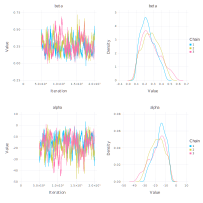

In [43]:
p = Mamba.plot(sim, legend = true)
Mamba.draw(p, nrow = 2, ncol = 2)

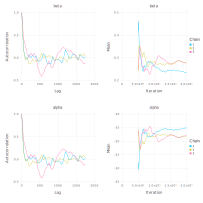

In [44]:
p = Mamba.plot(sim, [:autocor, :mean], legend=true)
Mamba.draw(p, nrow = 2, ncol = 2)

In [168]:
alpha_samples = sim[:, [:alpha], :].value[:]
beta_samples = sim[:, [:beta], :].value[:]

9000-element Array{Float64,1}:
 0.4304461071696167 
 0.4106708258456665 
 0.4195331770672434 
 0.4467836267055885 
 0.4596105771239893 
 0.49835423107684235
 0.4747802915543799 
 0.4391655218345188 
 0.4405393115299753 
 0.4510594983141693 
 0.49492723731684574
 0.497999569315592  
 0.4763985907777627 
 ⋮                  
 0.1649745764873938 
 0.19650926729047238
 0.20462016636645483
 0.19950665717238236
 0.2007724465470868 
 0.20769032874392057
 0.2003090171306111 
 0.24900225149375532
 0.23810368990364994
 0.24557230958384269
 0.23251655303669203
 0.23150431801471447

## (演習問題) $\alpha$に対して$\beta$をプロットする

In [175]:
scatter(alpha_samples, beta_samples, label = "", markersize = 3)

## 破損確率の事後期待値と、サンプルの中から二つ選んでプロットする

In [120]:
xs = collect((minimum(temperature) - 5):0.1:(maximum(temperature) + 5))
p_t = logistic(transpose(xs), alpha_samples, beta_samples)

9000×381 Array{Float64,2}:
 0.999414  0.999388  0.999361  0.999333  …  0.000140117  0.000134215
 0.999552  0.999534  0.999514  0.999494     0.000388312  0.000372694
 0.999711  0.999698  0.999685  0.999672     0.000429578  0.000411936
 0.999856  0.99985   0.999843  0.999836     0.000307988  0.000294534
 0.999683  0.999668  0.999653  0.999636     8.58418e-5   8.19861e-5 
 0.999467  0.99944   0.999411  0.999381  …  1.17516e-5   1.11803e-5 
 0.999733  0.99972   0.999706  0.999692     5.73611e-5   5.47015e-5 
 0.999864  0.999858  0.999851  0.999845     0.000433302  0.000414692
 0.999764  0.999754  0.999743  0.999731     0.000237802  0.000227555
 0.999744  0.999732  0.99972   0.999707     0.000146956  0.000140476
 0.999789  0.999779  0.999767  0.999756  …  3.38707e-5   3.22352e-5 
 0.999895  0.99989   0.999884  0.999879     6.07341e-5   5.77838e-5 
 0.999815  0.999806  0.999797  0.999787     7.79991e-5   7.43706e-5 
 ⋮                                       ⋱               ⋮          
 0.9260

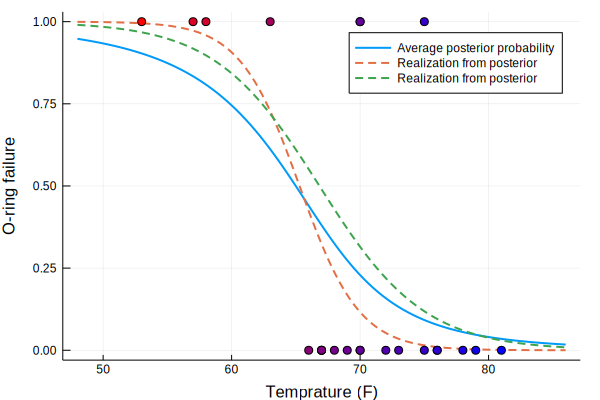

In [137]:
Plots.plot(xs, vec(mean(p_t, dims=1)), linewidth = 2, label = "Average posterior probability")
Plots.plot!(xs, p_t[1, :], linewidth = 2, linestyle = :dash, label = "Realization from posterior")
Plots.plot!(xs, p_t[end-2, :], linewidth = 2, linestyle = :dash, label = "Realization from posterior")
scatter!(challengers_data.temperature, challengers_data.incident, 
        markercolor = weighted_color_mean.(color_weight, colorant"blue", colorant"red"), 
        xlabel = "Temprature (F)", ylabel = "O-ring failure", label = "")

## 破損確率の事後期待値と、95%信頼区間をプロットする

In [157]:
p_t_ci = mapslices(x -> quantile(x, [0.025, 0.975]), p_t, dims = 1)

2×381 Array{Float64,2}:
 0.67402   0.67218   0.670427  …  3.77001e-5  3.57849e-5  3.38566e-5
 0.999936  0.999932  0.999929     0.109213    0.108228    0.10752   

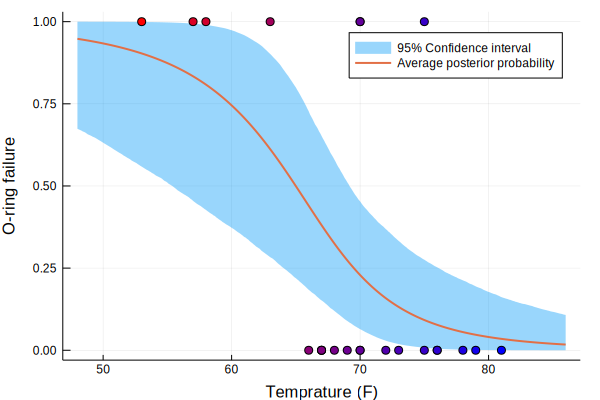

In [167]:
Plots.plot(xs, p_t_ci[2, :], linewidth = 0, 
    fillrange = p_t_ci[1, :], fillalpha = 0.4,
    label = "95% Confidence interval")
Plots.plot!(xs, vec(mean(p_t, dims=1)), linewidth = 2, label = "Average posterior probability")
scatter!(challengers_data.temperature, challengers_data.incident, 
        markercolor = weighted_color_mean.(color_weight, colorant"blue", colorant"red"), 
        xlabel = "Temprature (F)", ylabel = "O-ring failure", label = "")